# The Toy Shape Dataset

 - A toy shapes dataset: small resolution image composed of squares, circles an triangles.
 - Strongly inspired from [this implementation](https://github.com/matterport/Mask_RCNN/blob/cbff80f3e3f653a9eeee43d0d383a0385aba546b/samples/shapes/shapes.py).
 - The [config.yaml file](./config.yaml) should be able to train the dataset composed of 50 images in less than 10 minutes on a regular GPU with a **mAP@[0.5:0.95] of ~70%**.
 
This dataset is ideal for debugging and educational purpose..

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tqdm

import sys; sys.path.append("../../../")
import maskflow

import utils

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

# Load the configuration.
config = maskflow.load_config("config.yaml")

# Copy config next to data folder.
maskflow.save_config(config, root_dir / "config.yaml")

## Generate the dataset

In [2]:
height = config["DATASET"]["IMAGE_SIZE"]
width = config["DATASET"]["IMAGE_SIZE"]
class_names = config["DATASET"]["CLASS_NAMES"]

count = 50
min_n_per_image = 1
max_n_per_image = 4
training_size = 0.9  # From 0 to 1

image_format = "png"
masks_format = "png"

train_ids, _ = train_test_split(np.arange(0, count), train_size=training_size)

train_features_example = []
test_features_example = []

train_file_path = data_dir / "train.tfrecords"
test_file_path = data_dir / "test.tfrecords"

for image_id in tqdm.trange(count):
    # Generate image specification
    bg_color, shapes = utils.random_image(height, width, min_n_per_image, max_n_per_image, class_names)
    
    # Generate the image
    image = utils.generate_image(bg_color, height, width, shapes)
    
    # Generate the masks
    masks, label_ids = utils.generate_mask(bg_color, height, width, shapes, class_names)
    
    # Get a list of class from the object label ids.
    label_names = [class_names[class_id].encode("utf8") for class_id in label_ids]
    
    # Get bounding boxes from masks.
    bboxes = maskflow.bbox.from_masks(masks)
    
    filename = f"toy_{image_id:04d}.png"
    
    build_features_args = {}
    build_features_args['image'] = image
    build_features_args['image_id'] = image_id
    build_features_args['filename'] = filename
    build_features_args['image_format'] = image_format
    build_features_args['bboxes'] = bboxes
    build_features_args['masks'] = masks
    build_features_args['label_ids'] = label_ids
    build_features_args['label_names'] = label_names
    build_features_args['masks_format'] = masks_format
    features_dict = maskflow.dataset.build_features_dict(**build_features_args)
    
    example = tf.train.Example(features=tf.train.Features(feature=features_dict))
    
    if image_id in train_ids:
        train_features_example.append(example)
    else:
        test_features_example.append(example)
        
# Write examples to TFRecord files.
with tf.io.TFRecordWriter(str(train_file_path)) as writer:
    for example in train_features_example:
        writer.write(example.SerializeToString())
        
with tf.io.TFRecordWriter(str(test_file_path)) as writer:
    for example in test_features_example:
        writer.write(example.SerializeToString())

100%|██████████| 50/50 [00:04<00:00,  8.79it/s]


## Visualize some images with their masks

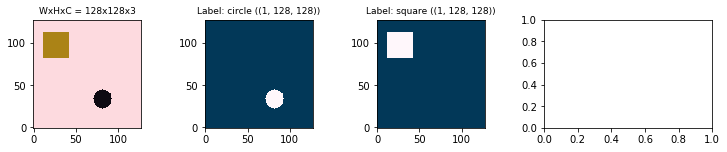

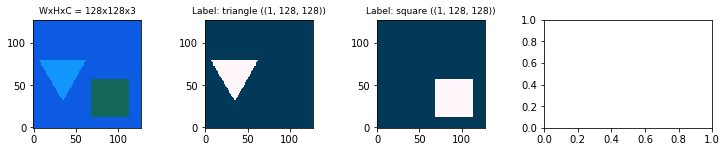

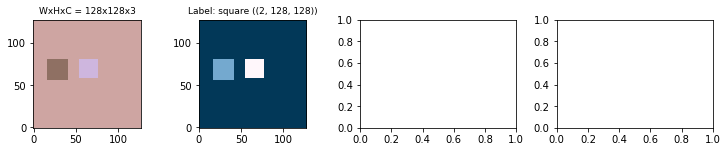

In [5]:
class_names = config["DATASET"]["CLASS_NAMES"]

# Load, parse and preprocess a dataset.
train_dataset = maskflow.dataset.parse(train_file_path, config, do_preprocess=True)

# Shuffle the dataset and select few features from it.
dataset_to_display = train_dataset.shuffle(1000).take(3)

# Display
maskflow.viz.batch_display_top_masks(dataset_to_display, class_names, basesize=10, limit=3, cmap="PuBu_r")

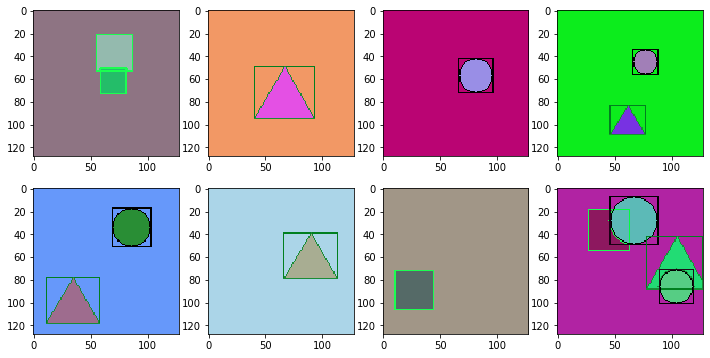

In [6]:
# You can also draw objects on images.

draw_args = {}
draw_args['dataset'] = train_dataset.take(8)
draw_args['class_names'] = class_names
draw_args['draw_bbox'] = True
draw_args['draw_true_label'] = False
draw_args['draw_mask'] = True
draw_args['draw_contour'] = True
draw_args['rectangle_line_thickness'] = 1
draw_args['text_line_thickness'] = 1
draw_args['mask_alpha'] = 0.1
draw_args['contour_line_thickness'] = 1

overlays = maskflow.viz.draw_dataset(**draw_args)

# Plot
fig, axs = plt.subplots(ncols=4, nrows=int(len(overlays) / 4), figsize=(12, 6))
for ax, overlay in zip(axs.flatten(), overlays):
    ax.imshow(overlay)

In [7]:
dataset = train_dataset.take(8)

for feature in dataset:
    image = feature['image'].numpy()
    masks = feature['masks'].numpy()
    bboxes = feature['bboxes'].numpy()
    label_ids = feature['label_ids'].numpy()
    label_names = feature['label_names'].numpy()

    to_keep = label_ids > -1
    masks = masks[to_keep]
    bboxes = bboxes[to_keep]
    label_ids = label_ids[to_keep]
    label_names = label_names[to_keep]

In [8]:
blended = alpha * image0 + (1 - alpha) * image1

(4, 128, 128)

In [118]:
def blend_image_with_masks(image, masks, colors, alpha=0.5):
    """Add transparent colored mask to an image.

    Args:
        image: `np.ndarray`, the image of shape (width, height, channel) or (width, height).
        masks: `np.ndarray`, the mask of shape (n, width, height).
        colors: list, a list of RGB colors (from 0 to 1).
        alpha: float, transparency to apply to masks.

    Returns:
        `np.ndarray`
    """
    
    if image.dtype != "uint8":
        raise Exception("The image needs to be of type uint8. "
                        f"Current type is: {image.dtype}.")

    image = image.copy()
    image = image / 255

    colored = np.zeros(image.shape, dtype="float32")

    if image.ndim == 2:
        image = np.stack([image, image, image], axis=-1)

    for color, mask in zip(colors, masks):

        rgb_mask = np.stack([mask, mask, mask], axis=-1)
        rgb_mask = rgb_mask.astype('float32') * alpha

        colored = np.ones(image.shape, dtype='float32') * color
        image = colored * rgb_mask + image * (1 - rgb_mask)

    image = image * 255
    return image.astype("uint8")

In [122]:
from PIL import Image
image = Image.open("/home/hadim/test.jpg")
image = np.array(image)

image = image.mean(axis=-1)
image = image.astype("uint8")

colors = [(1, 0, 0), (0, 1, 0), (1, 0, 0), (0, 1, 1)]

image_blended = blend_image_with_masks(image, masks, colors, alpha=0.2)

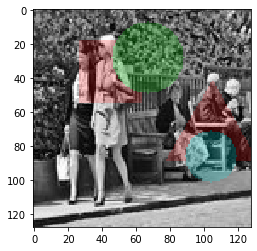

In [123]:
plt.imshow(image_blended)

In [53]:
im.shape

(307, 400, 3)